# Deeper Networks for Image Classification

## VGG16 Model for MNIST Image Classification

- Code by: Kaviraj Gosaye
- Student ID: 220575371

In [1]:
# GPU details
output = !nvidia-smi
for line in output:
    print(line)
    if line.strip() == "":
        break

Sat May  4 15:19:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   52C    P8             15W /  105W |     559MiB /   8192MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import psutil
# Get virtual memory information
virtual_memory = psutil.virtual_memory()
v_mem = virtual_memory.available / (1024 ** 3)

# Print available virtual memory
print("Available virtual memory:", v_mem)

Available virtual memory: 9.234233856201172


### 0. Imports

In [3]:
# import libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torchinfo import summary
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from datetime import datetime

### 1. Data Loading and Preprocessing

In [4]:
# transform PIL image to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5), (0.5))])

# load mnist dataset
train_set = torchvision.datasets.MNIST(root='../datasets', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='../datasets', train=False, download=True, transform=transform)
                                    
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=8)

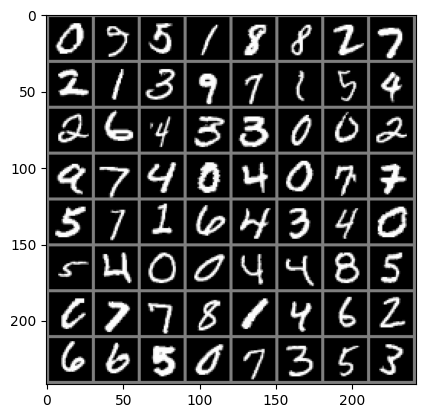

In [5]:
# extract one sample from the training set
dataiter = iter(train_loader)
# images, labels = dataiter.next()
images, labels = next(dataiter)

# plot the image
def imshow(img):
    # reverse normalization
    img = img / 2 + 0.5
    # convert tensor to numpy array
    npimg = img.numpy()
    # rearrange the dimensions to match matplotlib format
    # matplotlib:   H x W x C
    # torch:        C x H x W
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(images))

### 2. Model Building

In [6]:
# defining the VGG16 layers
VGG16_layers = [64, 64, "M", 128, 128, "M", 256, 256, 256, "A", 512, 512, 512, "A", 512, 512, 512, "M" ]

In [7]:
# creating a class of the VGG16 model
class VGG16(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000):
        super(VGG16, self).__init__()
        # inpuy layer
        self.in_channels = in_channels
        # hidden layers
        self.hidden_layers = self.conv_layers(VGG16_layers)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        # output layer
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    # function to create the hidden convolutional layers
    def conv_layers(self, layer_types):
        layers = []
        in_channels = self.in_channels

        for layer in layer_types:
            if type(layer) == int:
                out_channels = layer
                layers += [ nn.Conv2d( in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), ), nn.BatchNorm2d(layer), nn.ReLU()]
                in_channels = layer
            # max pooling layer
            elif layer == "M":
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]
            # average pooling layer
            elif layer == "A":
                layers += [nn.AdaptiveAvgPool2d((14,14))]

        return nn.Sequential(*layers)

In [8]:
# setting the device to cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# creating instance of model and setting it to the device
vgg16 = VGG16(in_channels=1, num_classes=10).to(device)

In [9]:
# visualize the model
info = summary(vgg16, (1, 1, 28, 28), col_names = ('input_size', 'output_size', 'num_params', 'kernel_size'))
print(info)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
VGG16                                    [1, 1, 28, 28]            [1, 10]                   --                        --
├─Sequential: 1-1                        [1, 1, 28, 28]            [1, 512, 7, 7]            --                        --
│    └─Conv2d: 2-1                       [1, 1, 28, 28]            [1, 64, 28, 28]           640                       [3, 3]
│    └─BatchNorm2d: 2-2                  [1, 64, 28, 28]           [1, 64, 28, 28]           128                       --
│    └─ReLU: 2-3                         [1, 64, 28, 28]           [1, 64, 28, 28]           --                        --
│    └─Conv2d: 2-4                       [1, 64, 28, 28]           [1, 64, 28, 28]           36,928                    [3, 3]
│    └─BatchNorm2d: 2-5                  [1, 64, 28, 28]           [1, 64, 28, 28]           128                       --
│    └

### 3. Model Training and Evaluation

In [10]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)

# open log file in write mode
log_file = open("../logs/vgg16_mnist_log.txt", "w")

start = time.time()

num_epochs = 10

train_losses = []
train_accs = []
test_losses = []
test_accs = []

test_correct = 0
total = 0

predicted_labels = []
true_labels = []


for epoch in range(num_epochs):
    running_train_loss = 0.0
    running_train_acc = 0.0
    running_test_loss = 0.0
    running_test_acc = 0.0
    correct = 0.0
    avg_test_loss = 0
    batch_loss = 0.0
    batch_acc = 0.0

    # setting the model to train mode
    vgg16.train()
    
    # loop over the training set
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # cumulative loss
        running_train_loss += loss.item()
        # batch loss for logging
        batch_loss += loss.item()

        # cumulative accuracy
        pred = outputs.argmax(dim=1, keepdim=True)

        # reshaping the labels to match the shape of the predictions
        # comparing the predictions to the labels using element-wise comparison
        # summing the correct predictions
        correct = pred.eq(labels.view_as(pred)).sum().item()
        running_train_acc += 100. * (correct / len(pred))

        # batch accuracy for logging
        batch_acc += 100. * (correct / len(pred))
        # printing the average loss every 100 mini-batches
        if i % 100 == 99:
             # Get current timestamp
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            # Write loss to log file
            log_file.write(f"{timestamp} - [{epoch + 1}, {i + 1}] loss: {batch_loss/100} accuracy: {batch_acc/100}\n")
            print(f"[{epoch + 1}, {i + 1}] loss: {batch_loss/100} accuracy: {batch_acc/100}")
            batch_loss = 0.0
            batch_acc = 0.0

    train_accs.append(running_train_acc/len(train_loader))
    train_losses.append(running_train_loss/len(train_loader))


    ##############################

    # setting the model to evaluation mode
    vgg16.to(device)
    vgg16.eval()


    # Disable gradient calculation
    with torch.no_grad():
        # Using test set
        for i, data in enumerate(test_loader, 0):

            images, labels = data[0].to(device), data[1].to(device)
            
            # Forward pass
            outputs = vgg16(images)
            
            # Calculate the test loss
            loss = criterion(outputs, labels)
            avg_test_loss += loss.item()

            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)
            
            # Update the total and correct predictions
            total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            # Append the predicted and true labels to be used for confusion matrix
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
            running_test_loss += loss.item()
            running_test_acc += 100 * test_correct / total

           
        test_losses.append(running_test_loss/len(test_loader))
        test_accs.append(running_test_acc/len(test_loader))

training_time = f'{(time.time() - start)/60.0:.2f}'
log_file.write(f"Finished Training after {training_time} minutes\n")
print(f"Finished Training after {training_time} minutes")

# Close the log file
log_file.close()

[1, 100] loss: 0.8327359376847744 accuracy: 72.5625
[1, 200] loss: 0.14484827637672423 accuracy: 95.75
[1, 300] loss: 0.10513456784188747 accuracy: 96.859375
[1, 400] loss: 0.12150381891056895 accuracy: 96.734375
[1, 500] loss: 0.10553249257616698 accuracy: 96.90625
[1, 600] loss: 0.07603381389286369 accuracy: 97.875
[1, 700] loss: 0.09213822308927774 accuracy: 97.390625
[1, 800] loss: 0.07757071097614243 accuracy: 97.796875
[1, 900] loss: 0.07310133891412988 accuracy: 98.109375
[2, 100] loss: 0.07096986156946514 accuracy: 97.8125
[2, 200] loss: 0.05711271379317623 accuracy: 98.4375
[2, 300] loss: 0.04938864517956972 accuracy: 98.515625
[2, 400] loss: 0.046889657497376905 accuracy: 98.765625
[2, 500] loss: 0.05859852979250718 accuracy: 98.28125
[2, 600] loss: 0.07283994603087195 accuracy: 98.078125
[2, 700] loss: 0.0457452283782186 accuracy: 98.8125
[2, 800] loss: 0.06317735558841378 accuracy: 98.390625
[2, 900] loss: 0.06188879272551276 accuracy: 98.390625
[3, 100] loss: 0.04093794160

In [11]:
# save model after training
torch.save(vgg16, "../Models/vgg16_mnist.pth")

### 4. Model Results and Plots

In [12]:
# print final accuracy
# get the final value of train_acc

print(f"Train Accuracy: {train_accs[-1]} %")
print(f"Test Accuracy: {test_accs[-1]} %")

print(f"Train Loss: {train_losses[-1]}")
print(f"Test Loss: {test_losses[-1]}")

Train Accuracy: 99.46528518123668 %
Test Accuracy: 98.9256007334812 %
Train Loss: 0.019640307713081888
Test Loss: 0.03202413358000205


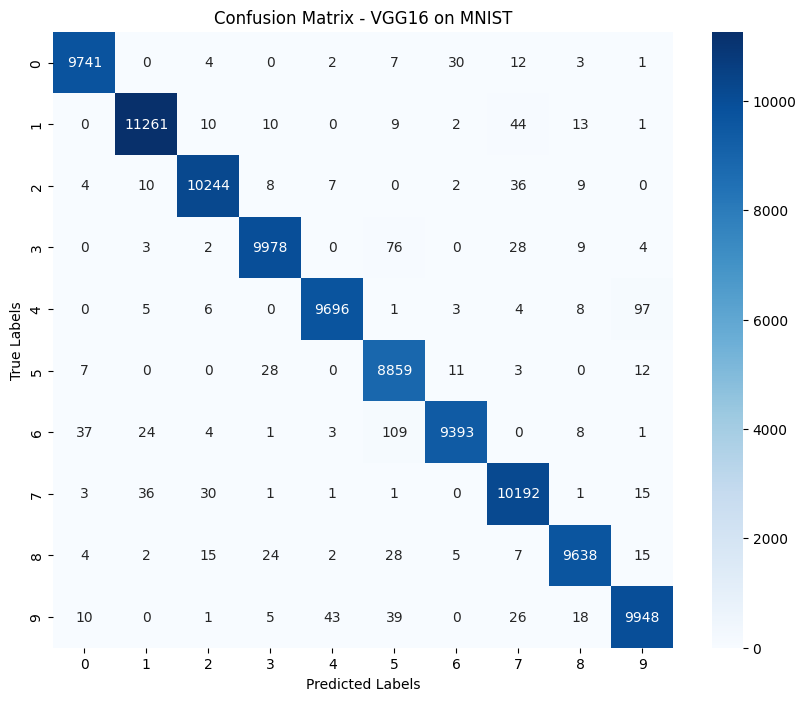

In [13]:
# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - VGG16 on MNIST")
plt.show()

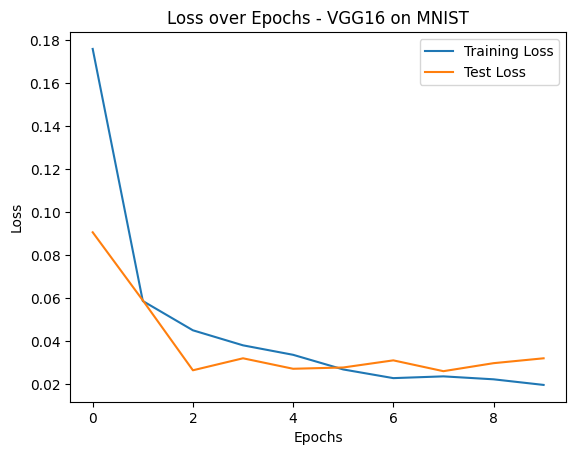

In [14]:
# plot the training loss and test loss over epochs
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs - VGG16 on MNIST")
plt.legend()
# save the plot
plt.savefig("./plots/Loss_VGG16_MNIST.png")
plt.show()

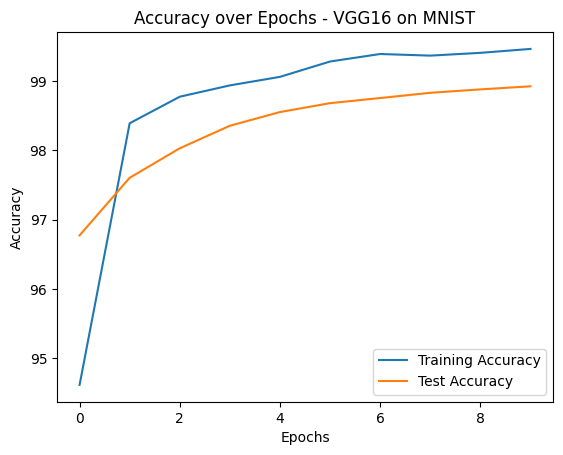

In [15]:
# plot the training accuracy and test accuracy over epochs
plt.plot(train_accs, label="Training Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs - VGG16 on MNIST")
plt.legend()
plt.savefig("./plots/Acc_VGG16_MNIST.png")
plt.show()

In [16]:
# print classification report
cr = classification_report(true_labels, predicted_labels)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9800
           1       0.99      0.99      0.99     11350
           2       0.99      0.99      0.99     10320
           3       0.99      0.99      0.99     10100
           4       0.99      0.99      0.99      9820
           5       0.97      0.99      0.98      8920
           6       0.99      0.98      0.99      9580
           7       0.98      0.99      0.99     10280
           8       0.99      0.99      0.99      9740
           9       0.99      0.99      0.99     10090

    accuracy                           0.99    100000
   macro avg       0.99      0.99      0.99    100000
weighted avg       0.99      0.99      0.99    100000



### 5. Model Testing

In [17]:
# loading some images from the test set
testloader = torch.utils.data.DataLoader(test_set, batch_size=30,shuffle=False)

dataiter = iter(testloader)
images, true_labels = next(dataiter)

In [18]:
# classes of mnist
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [19]:
# plotter function to plot the images
def plotter(images, true_labels, predicted_labels):
    correct = 0
    num_images = len(images)
    num_rows = (num_images) // 5
    fig, axs = plt.subplots(num_rows, 5, figsize=(15, 20))
    # setting the title
    fig.suptitle('True Label - [Predicted Labels]', fontsize=20)

    for ind in range(num_images):
        # plot image
        img = images[ind].permute(1, 2, 0) / 2 + 0.5
        ax = axs[ind // 5, ind % 5]
        ax.imshow(img, cmap='gray')

        # left - true label, right - predicted label
        if classes[true_labels[ind]] == classes[predicted_labels[ind]]:
            color = 'green'
            title = classes[true_labels[ind]] + ' - [' + classes[predicted_labels[ind]] + ']'
            ax.set_title(title, color=color)
            correct += 1
        else:
            color = 'red'
            title = classes[true_labels[ind]] + ' - [' + classes[predicted_labels[ind]] + ']'
            ax.set_title(title, color=color)        

    plt.tight_layout(pad=2.0)
    plt.show()
    print('Number of correct predictions: ', correct)
    print('Number of wrong predictions: ', num_images - correct)

In [20]:
# use model to predict images label
vgg16.eval()
vgg16.to('cpu')
outputs = vgg16(images)
_, predicted_labels = torch.max(outputs, 1)

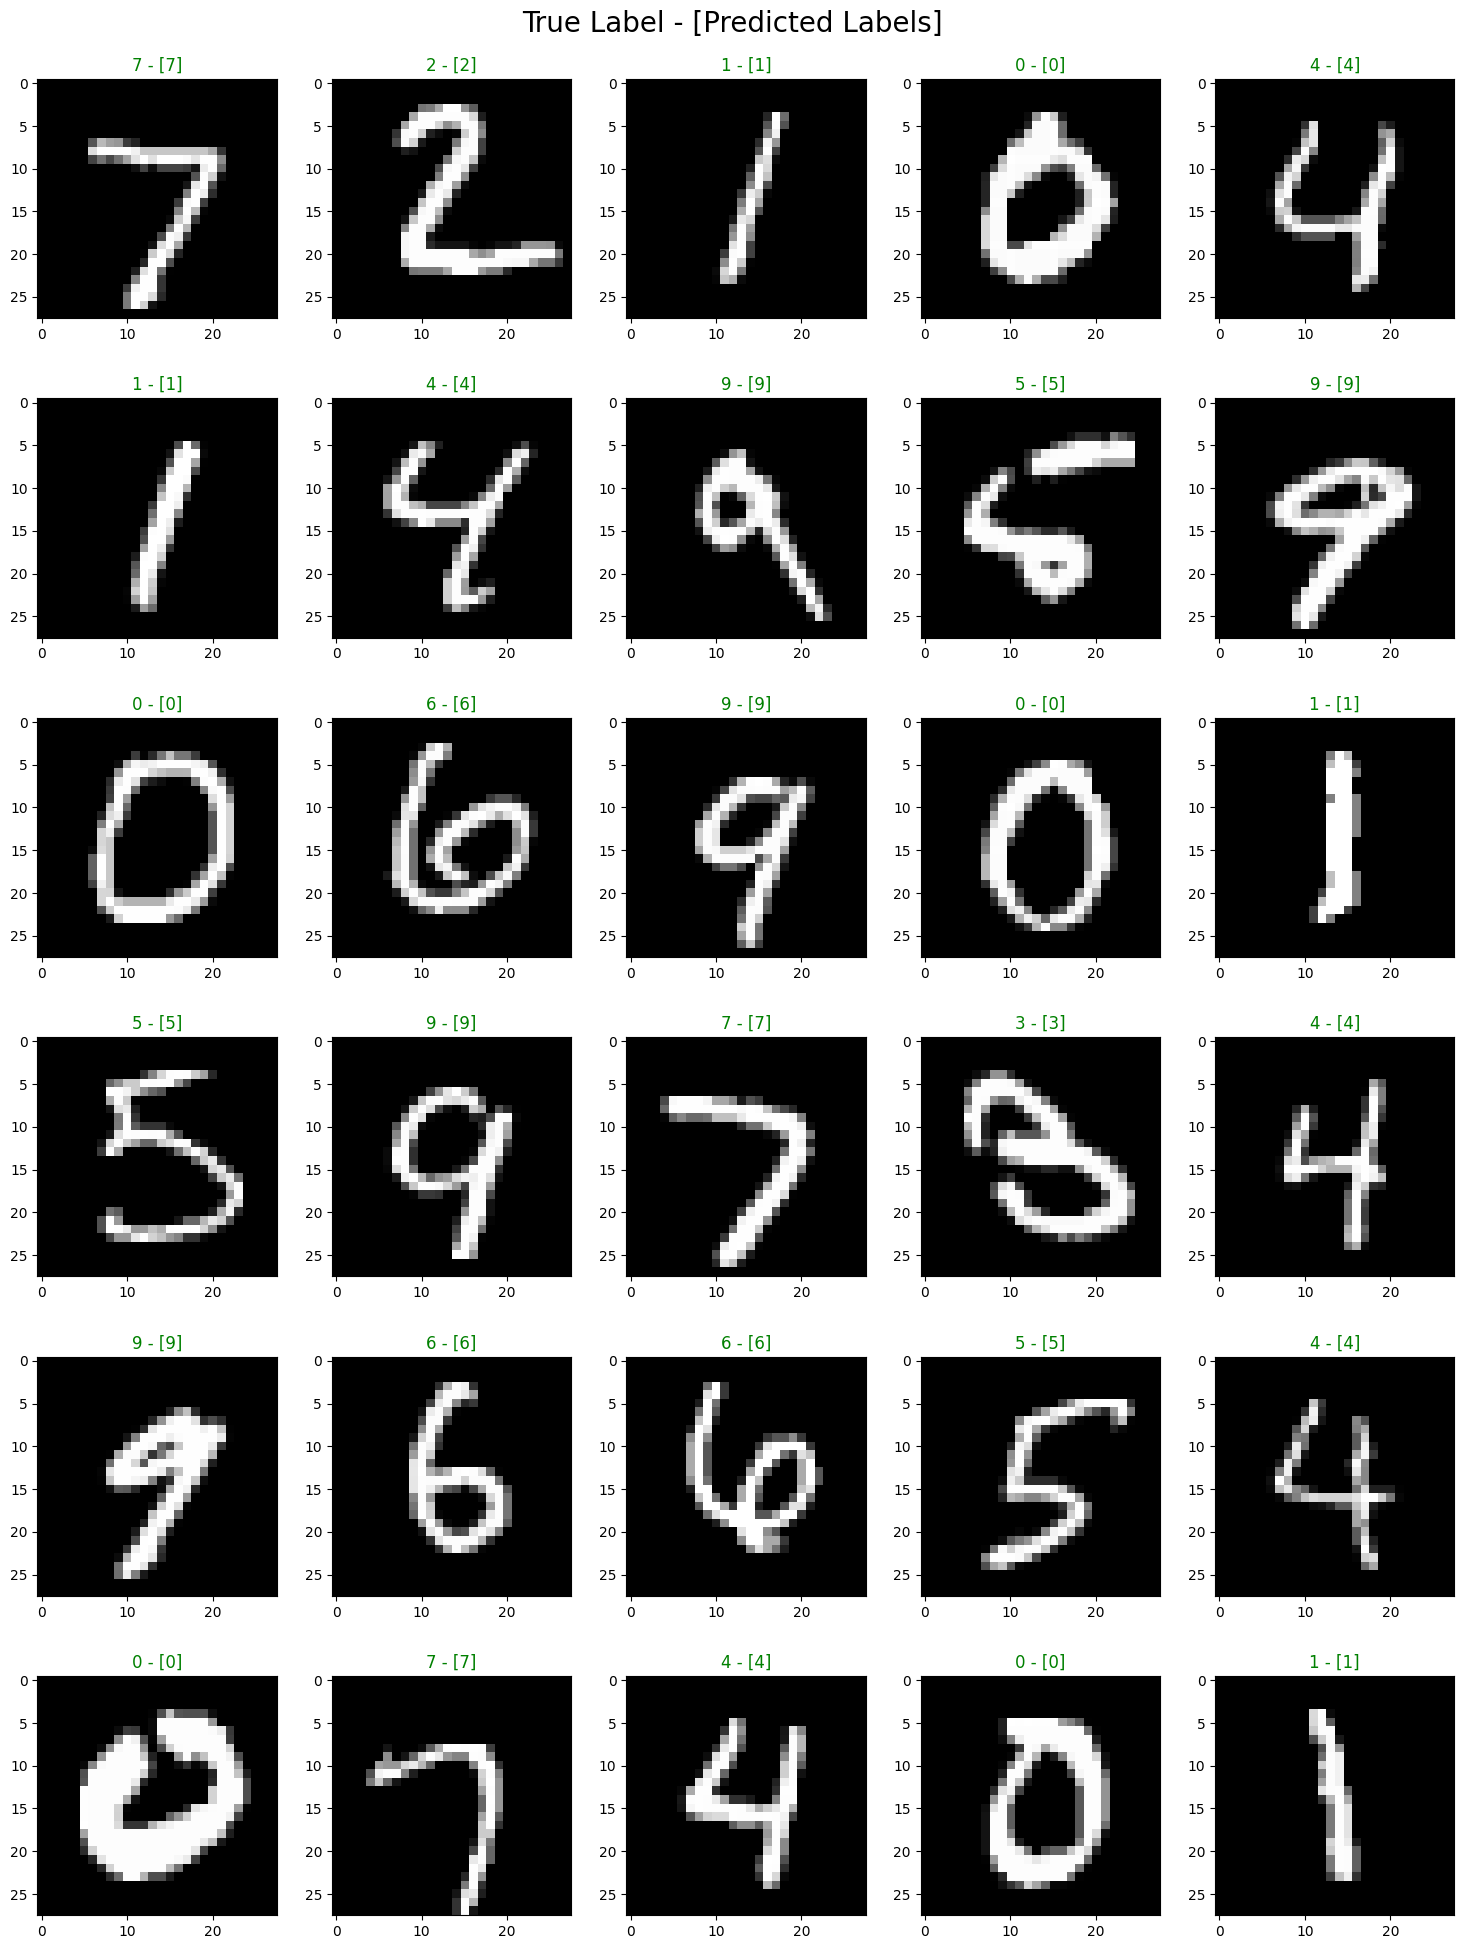

Number of correct predictions:  30
Number of wrong predictions:  0


In [21]:
# plot the images and predictions
plotter(images, true_labels, predicted_labels)